W pierwszym kroku należy załadować obraz, zmienić go na grayscale, znormalizować a potem zapisac do macierzy żeby zaczać wykonywać na nim operacje.

In [5]:
from PIL import Image
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

def loadImage(src):
    try:
        image = Image.open(src).convert("L")
    except IOError:
        print(f"Could not find file: {src}")
        return
    imgMatrix = np.asarray(image)
    # plotting for debug purpouses
    plt.matshow(imgMatrix, cmap=plt.cm.gray)
    plt.show()
    
    return imgMatrix

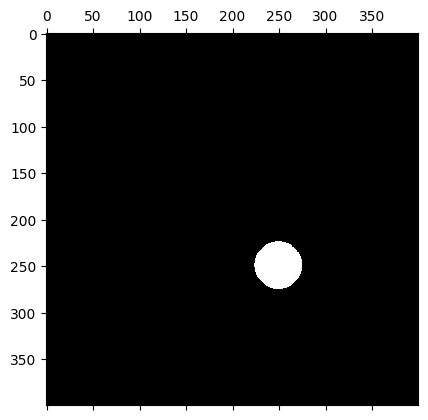

In [6]:
imgMatrix = loadImage("img/Kropka.jpg")

Następny etap to sinogram.

In [3]:
import numpy as np

def radon_transform(alpha = 45, phi_range = 90, num_detectors = 10, num_iterations = 5, image = imgMatrix):
    height, width = image.shape
    radius = int(np.sqrt(height**2 + width**2) // 2)
    x_offset = width // 2
    y_offset = height // 2
    phi_rad = np.radians(phi_range)

    for i in range(num_iterations):
        curr_alpha = i * np.radians(alpha) 
        xe = int(radius * np.cos(curr_alpha)) + x_offset
        ye = int(radius * np.sin(curr_alpha)) + y_offset
        
        for j in range(num_detectors):
            xd = int(radius * np.cos(curr_alpha + np.pi - (phi_rad / 2) + j * phi_rad/(num_detectors-1))) + x_offset
            yd = int(radius * np.sin(curr_alpha + np.pi - (phi_rad / 2) + j * phi_rad/(num_detectors-1))) + y_offset
            print(xd, yd, j)
        print("")

radon_transform()

1 399 0
-31 361 1
-55 319 2
-72 272 3
-80 224 4
-80 176 5
-72 128 6
-55 81 7
-31 39 8
1 1 9

-82 200 0
-77 152 1
-64 104 2
-44 60 3
-16 19 4
19 -16 5
59 -44 6
104 -64 7
152 -77 8
200 -82 9

1 1 0
39 -31 1
81 -55 2
128 -72 3
176 -80 4
224 -80 5
272 -72 6
319 -55 7
361 -31 8
399 1 9

200 -82 0
248 -77 1
296 -64 2
341 -44 3
381 -16 4
416 19 5
444 59 6
464 104 7
477 152 8
482 200 9

399 1 0
431 39 1
455 81 2
472 128 3
480 176 4
480 224 5
472 272 6
455 319 7
431 361 8
399 399 9

